Here is the submission for predicting farmer crop yields 2 months in advance.
Lots of work was done on specifying which data to train off on, and making relevant predictions when need be;
for example, data was turned into a time-series style data, then learned from that.


Link to presentation: https://www.youtube.com/watch?v=XuMe_tfv1WY
I used pytorch for this project. Inference time and complexity speeds weren't something I thought too much about - however given that the NN is quite small, it'll be easy to quantize it to maybe 16KB in size, and have ridiculously fast inference times.

General pipeline:

1) Load in data, do the data cleaning from having done basic data analysis

2) Train random forests on this data, use these to further clean the data

3) Train random forests on this further set of cleaned data

4) Use neural networks on this cleaned data to allow for predicting outlier data

5) Check to see that NNs do well, and if so, produce an ensembled model

If further time was given, producing NN embeddings would be something I'd do, and producing more complex model ensembles. One of the techniques for making interesting models is by converting tabular data into image data, then running a CNN through it, this could product more interesting results.

It seems, in hindsight, that the data has fairly low variance, so complex models may not do much, but if the time allows for it, trying it could be done when the interest permits.

In [ ]:
## IMPORTS
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

     |████████████████████████████████| 727kB 19.8MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 194kB 51.1MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
     |████████████████████████████████| 1.2MB 56.6MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
Mounted at /content/gdrive


In [ ]:
# IMPORTANT !!!

# !mkdir /content/gdrive/MyDrive/aihack # for google colab runtimes
path = Path('/content/gdrive/MyDrive/ai/aihack2021') # use for colab-runtimes
# path = Path('XXX') # use for non-colab runtimes, XXX denotes folder in which crop data is in

In [ ]:
## READ IN DATA

dep_var = 'yield'
il_yield = pd.read_csv(path/'IL_yield.csv', low_memory=False)
evi_stacked = pd.read_csv(path/'EVI_stacked.csv', low_memory=False)
era5 = pd.read_csv(path/'ERA5.csv', low_memory=False)

# DATA PROCESSING

il_yield = il_yield[(il_yield['year']) > 2000]
df = pd.merge(evi_stacked , il_yield , on=['year', 'county'], how='inner')

evi_redact = ['evi_1', 'evi_17', 'evi_33', 'evi_49','evi_65', 'evi_81', 'evi_337','evi_353']
df=df.drop(evi_redact, axis=1)

def x_round(x): return round(x*4)/4
df['lat'] = df['lat'].apply(x_round)
df['long'] = df['long'].apply(x_round)

era5['time']=pd.to_datetime(era5['time'])
era5['year']=pd.DatetimeIndex(era5['time']).year
era5['day_of_year']=[x.timetuple().tm_yday for x in era5['time']]
era5 = era5.drop('time', axis=1)
era5 = era5[era5['year']>2000]

era5 = era5[era5['day_of_year']>90]
era5 = era5[era5['day_of_year']<(365-30)]

list1 =[91, 105, 118, 121, 135, 148, 152, 166, 179, 182, 196, 209, 213,
       227, 240, 244, 258, 271, 274, 288, 301, 305, 319, 332]
list2 = [92, 106,119, 122, 136, 149, 153, 167, 180, 183, 197, 210, 214, 228, 241,
         245, 259, 272, 275, 289, 302, 306, 320, 333]
era5.replace(to_replace = list2, value = list1, inplace = True)

for i in list1:
    d1 = era5[era5['day_of_year']==i]
    d1 = d1.drop(['county', 'day_of_year'], axis=1)
    d1.rename(columns={"t2m":"temp_{}".format(i)}, inplace=True)
    df = pd.merge(df , d1 , on=['year', 'lat', 'long'], how='inner')


df = df.drop(['evi_289', 'evi_305', 'evi_321'], axis=1)
df = df.drop(['temp_288', 'temp_301', 'temp_305', 'temp_319',
       'temp_332'], axis=1)

# bad columns dropped due to poor scalability and useless insight
# determined after examining random forest

df = df.drop(['year', 'county'], axis=1)

In [ ]:
# Metrics

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
## RANDOM FORESTING

procs = [Categorify, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

# We don't use categorical data, so this is for generability
def cont_cat_split(df, max_card=20, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label in L(dep_var): continue
        
        # mod to detect ProductSize type properly
        if (df[label].dtype.name == 'category'):
          cat_names.append(label)
          continue

        if (np.issubdtype(df[label].dtype, np.integer) and
            df[label].unique().shape[0] > max_card or
            np.issubdtype(df[label].dtype, np.floating)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

def rf(xs, y, n_estimators=200, max_samples=30000,
       max_features=0.5, min_samples_leaf=20, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

# generalisation & eval
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(7.273396, 7.546122)

In [ ]:
## PREDICTION INTERPRETATION

preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds_std = preds.std(0)
preds_std[:10]

# somewhat unconfident predictions are found

array([5.93083151, 4.04986935, 6.89926978, 4.65188649, 6.31777224, 4.55379559, 4.73862734, 3.6204936 , 3.38031621, 2.46274513])

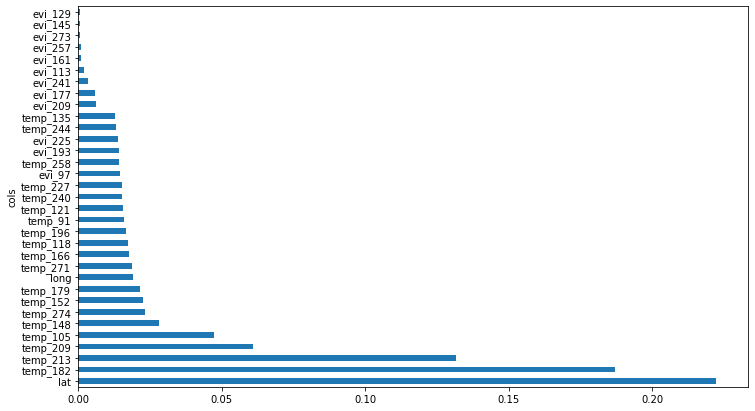

In [ ]:
# Feature Importance

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False,
                   )

fi = rf_feat_importance(m, xs)
plot_fi(fi);

In [ ]:
valid_xs.iloc[:1]

,long,lat,evi_97,evi_113,...,temp_244,temp_258,temp_271,temp_274
11454,-89.75,39.25,0.223076,0.257828,...,300.661377,300.347198,293.655609,298.953125


In [ ]:
def pred_ci(model, x_val, percentile = 95):   
    
    """
    x_val = validation input
    percentile = required confidence level
    model = random forest model
    """

    allTree_preds = np.stack([t.predict(x_val) for t in model.estimators_], axis = 0)
    
    err_down = np.percentile(allTree_preds, (100 - percentile) / 2.0  ,axis=0)
    err_up = np.percentile(allTree_preds, 100- (100 - percentile) / 2.0  ,axis=0)
    
    ci = err_up - err_down
    yhat = model.predict(x_val)
    
    df = pd.DataFrame()
    df['down'] = err_down 
    df['up'] = err_up
    df['y'] = y
    df['yhat'] = yhat
    df['deviation'] = (df['up'] - df['down'])/df['yhat']
    df.reset_index(inplace=True)
    df_sorted = df.iloc[np.argsort(df['deviation'])[::-1]]
    return df_sorted

In [ ]:
pred_ci(m, valid_xs).sort_values(by=['deviation'], ascending=False)

,index,down,up,y,yhat,deviation
3974,3974,23.773779,125.538396,134.0,60.593995,1.679451
4813,4813,22.938441,77.422877,150.0,34.546591,1.577129
4086,4086,31.523339,106.842569,157.0,50.714775,1.485154
14388,14388,31.761788,91.400101,127.0,51.456643,1.159001
7790,7790,31.761788,88.604677,113.0,50.916581,1.116392
...,...,...,...,...,...,...
3414,3414,184.597500,187.775700,154.0,185.864741,0.017100
16162,16162,184.599000,187.775700,NaN,185.875821,0.017090
7130,7130,184.598793,187.775700,NaN,185.892871,0.017090
12361,12361,184.581250,187.563262,171.0,185.825957,0.016047


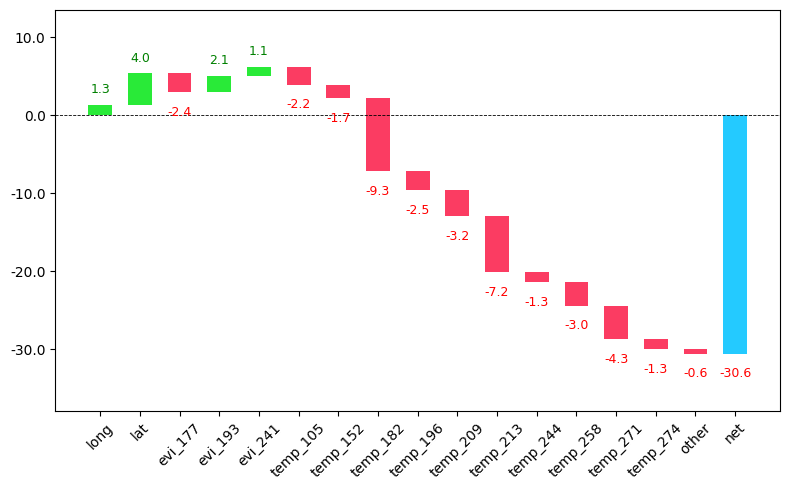

In [ ]:
# Tree interpretor

import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

row = valid_xs.iloc[:1]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)
prediction[0], bias[0], contributions[0].sum()

plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
waterfall(valid_xs.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.1f}');

In [ ]:
# This is a good
r_mse(m.oob_prediction_, y)

7.67927

In [ ]:
!pip install PDPbox

     |████████████████████████████████| 57.7MB 56kB/s 
  Created wheel for PDPbox: filename=PDPbox-0.2.0-cp37-none-any.whl size=57690722 sha256=2ba15c17f56fb94f9371a980958f1f71149880ce92a1d4f101a7e7286c7838da
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built PDPbox


In [ ]:
valid_xs.columns

Index(['long', 'lat', 'evi_97', 'evi_113', 'evi_129', 'evi_145', 'evi_161',
       'evi_177', 'evi_193', 'evi_209', 'evi_225', 'evi_241', 'evi_257',
       'evi_273', 'temp_91', 'temp_105', 'temp_118', 'temp_121', 'temp_135',
       'temp_148', 'temp_152', 'temp_166', 'temp_179', 'temp_182', 'temp_196',
       'temp_209', 'temp_213', 'temp_227', 'temp_240', 'temp_244', 'temp_258',
       'temp_271', 'temp_274'],
      dtype='object')

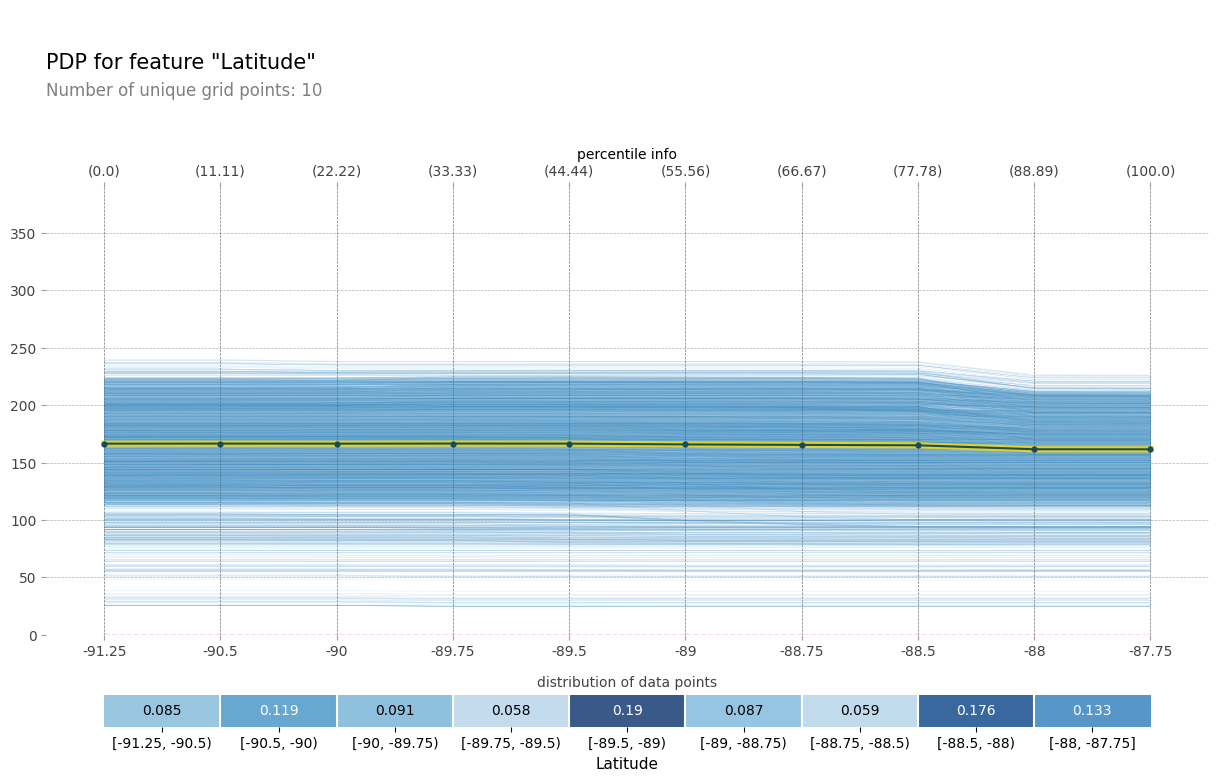

In [ ]:
from pdpbox import pdp, info_plots
pdp_age = pdp.pdp_isolate( model=m, dataset=valid_xs, model_features=valid_xs.columns, feature='long' ) 
# #PDP Plot 
# fig, axes = pdp.pdp_plot(pdp_age, 'Age', plot_lines=False, center=False, frac_to_plot=0.5, plot_pts_dist=True,x_quantile=True, show_percentile=True) 
#ICE Plot 
fig, axes = pdp.pdp_plot(pdp_age, 'Latitude', plot_lines=True, center=False, frac_to_plot=0.5, plot_pts_dist=True,x_quantile=True, show_percentile=True)

In [ ]:
inter1 = pdp.pdp_interact(model=m, dataset=valid_xs, model_features=valid_xs.columns, features=['long', 'lat']) 
fig, axes = pdp.pdp_interact_plot( pdp_interact_out=inter1, feature_names=['long', 'lat']) 
axes['pdp_inter_ax'].set_yticklabels([edu_map.get(col) for col in axes['pdp_inter_ax'].get_yticks()])

In [ ]:
`# Data extraction and accuracy checks

to_keep = fi[fi.imp>0.005].cols
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(7.3046, 7.513435)

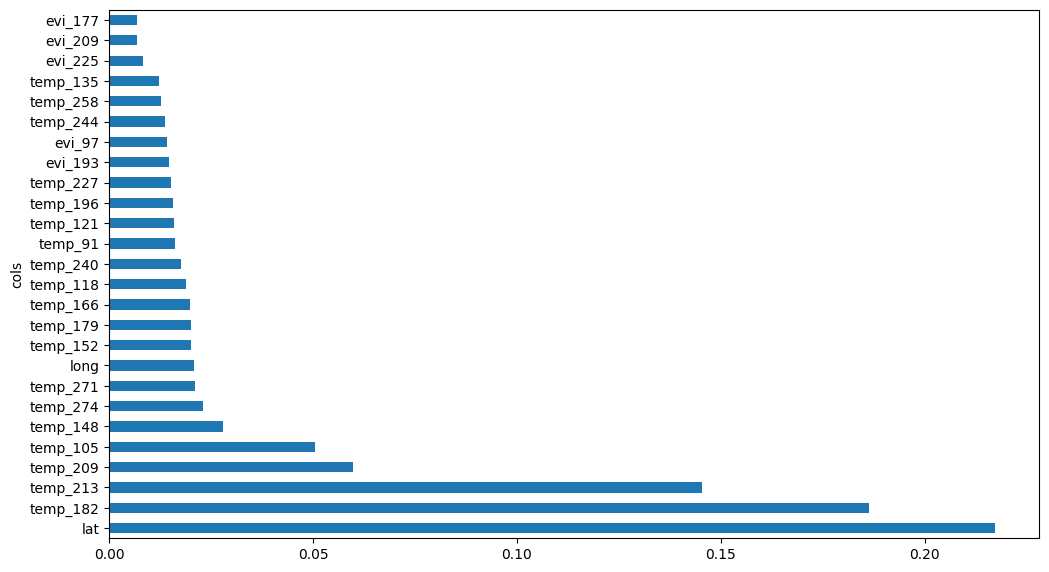

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

In [ ]:
from sklearn.inspection import plot_partial_dependence

l = list('this list contains needed xs_imp columns')

fig,ax = plt.subplots(figsize=(10, 5))
plot_partial_dependence(m, valid_xs_imp, l,
                        grid_resolution=20, ax=ax);

In [ ]:
# SAVE MODEL
xs_final = xs_imp
valid_xs_final = valid_xs_imp

save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0006918309954926372)

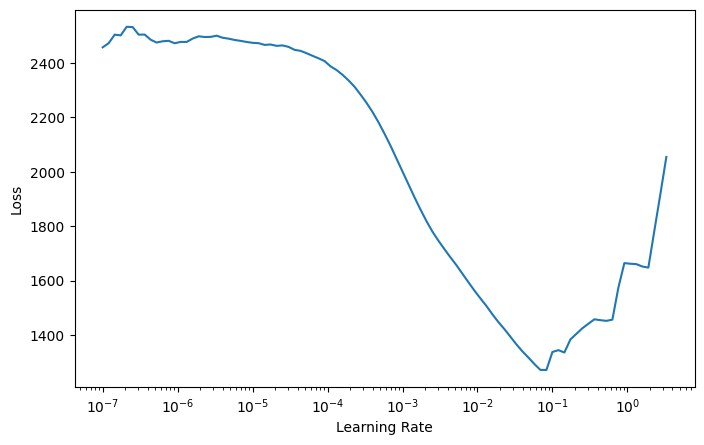

In [ ]:
## 2 - NEURAL NET

cont_nn,cat_nn = cont_cat_split(df, max_card=9000, dep_var=dep_var)
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

dls = to_nn.dataloaders(1024)
y = to_nn.train.y
ymin = math.floor(y.min())
ymax = math.ceil(y.max())

learn = tabular_learner(dls, y_range=(ymin, ymax), layers=[250,125],
                        n_out=1, loss_func=F.mse_loss)

# fine tune learning rate
learn.lr_find()

In [ ]:
# learner and predictions

learn.fit_one_cycle(150, 1e-2)
preds,targs = learn.get_preds()
r_mse(preds,targs)

In [ ]:
## 3 - MODEL COMBINATION

rf_preds = m.predict(valid_xs_imp)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2
r_mse(ens_preds,valid_y)

7.206286

In [ ]:
# SAVE MODEL

learn.save(path/'nn')

Path('/content/gdrive/MyDrive/aihack/aihack2021/nn.pth')

In [ ]:
### Final metrics and plots

!pip install -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import max_error, median_absolute_error, r2_score

# import seaborn as sns
print("mean absolute error:            " + str(round(mean_absolute_error(ens_preds, valid_y), 2)))
print("root mean squared error:        " + str(round(mean_squared_error(ens_preds, valid_y, squared=False))))
print("mean squared error:             " + str(round(mean_squared_error(ens_preds, valid_y), 2)))
print("explained variance score:       " + str(round(explained_variance_score(ens_preds, valid_y), 2)))
print("max error:                      " + str(round(max_error(ens_preds, valid_y))))
# print("mean absolute percentage error: " + str(round(mean_absolute_percentage_error(ens_preds, valid_y)))) not available?!
print("mean absolute error:            " + str(round(mean_absolute_error(ens_preds, valid_y))))
print("r2 score:                       " + str(round(r2_score(ens_preds, valid_y), 2)))

# plt.scatter(valid_y, ens_preds)
# plt.plot(valid_y, valid_y, 'r')
# sns.distplot(valid_y-ens_preds)

mean absolute error:            5.11
root mean squared error:        7
mean squared error:             51.93
explained variance score:       0.94
max error:                      54
mean absolute error:            5
r2 score:                       0.94
